# Crack Detection

<div style="background-color: whitesmoke; padding: 30px; padding-top: 10px;">
    <h2>Table of Contents</h2>
    <div><a href="#S1">1. Introduction</a></div>
    <div><a href="#S2">2. Load and Inspect Data</a></div>
    <div><a href="#S3">3. Build Models</a></div>
    <div><a href="#S4">4. Train the Models</a></div>
    <div><a href="#S5">5. Model Prediction and Evaluation</a></div>
</div>

## <a id="S1"></a> 1. Introduction

The detection of cracks in various structures is a critical task in civil engineering and maintenance. Early and accurate identification of cracks can prevent catastrophic failures and reduce maintenance costs. This notebook demonstrates a machine learning approach to automatically detect cracks in concrete surfaces using image data. 

The project was completed for the [IBM AI Capstone Project with Deep Learning](https://www.coursera.org/learn/ai-deep-learning-capstone/home/welcome), and the dataset used was provided by IBM.

### Install and import libraries

In [1]:
# !pip -q install numpy
# !pip -q install matplotlib
# !pip -q install pandas
# !pip -q install PIL
# !pip -q install os

In [2]:
from PIL import Image

import pandas
import os
import random
import numpy as np

import matplotlib.pylab as plt
from matplotlib.pyplot import imshow

import torch
from torch import nn
from torch import optim 
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset

## <a id="S2"></a> 2. Load and Inspect Data

This analysis utilises a dataset provided by IBM for their AI Capstone project. The dataset comprises images of concrete structures categorised as either containing cracks (located in the 'Positive' subfolder) or being crack-free (located in the 'Negative' subfolder). The dataset's directory structure is as follows:

```python
Concrete/
└── Negative
└── Positive
```

### Configurations

In [3]:
torch.manual_seed(0) # For reproducibility
batch_size = 100

### Define data augmentation (transform)

In [4]:
# Normalization parameters are based on ImageNet statistics
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform =transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to tensor 
    transforms.Normalize(mean, std) # Normalize tensor
])

### Define dataset and data loading process

We create a custom `Dataset` class to efficiently load and manage our image data. This class handles accessing images and their corresponding labels.

We create `DataLoader` objects to efficiently load data in batches during training and validation. 

In [5]:
# Define Dataset class
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        """ Constructor for Dataset class. """
        
        # The transform is goint to be used on image
        self.transform = transform
        
        directory = "data/Concrete" # Main data directory
        negative = 'Negative' # Subdirectory for images without cracks
        positive = 'Positive' # Subdirectory for images with cracks

        # Get all filenames in the Negative and Positive folders
        negative_file_path=os.path.join(directory,negative) 
        positive_file_path=os.path.join(directory,positive)

        # Find all filenames ending with ".jpg" in the Negative and Positive folders. Add directory path infront of all filenames.
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]

        # Sort the file paths
        negative_files.sort()
        positive_files.sort()

        # Create balanced dataset: cracked (positive) at even indices, non-cracked (negative) at odd indices
        number_of_samples = len(negative_files) + len(positive_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        
        # Create labels: 1 for cracked, 0 for non-cracked
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        # Split into training and validation sets
        if train:
            self.Y=self.Y[0:30000]
            self.len=len(self.Y)
        else:
            self.Y=self.Y[30000:]
            self.len=len(self.Y)
       
    # Get the length
    def __len__(self):
        """Return the number of samples in the dataset."""
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        """ Get a sample from the dataset. """
        
        image=Image.open(self.all_files[idx]) # Open image
        y=self.Y[idx] # Get label
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

# Create datasets
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False) 

### Visualise data

To get an idea of the type of images we are working with, we will display a few sample images from the training and validation sets.

In [73]:
def show_data(dataset, title, plot_idx=None):
    """ Displays sample images from the dataset."""
    if plot_idx is None:   
        plot_idx = [random.randint(0, len(dataset) - 1) for _ in range(3)]  # Get 3 random indices
    fig, ax = plt.subplots(1, len(plot_idx), figsize=(16, 6)) # Create subplots
    class_names = ['No Crack', 'Crack'] # Class names for display
    fig.suptitle(title, fontsize=20, fontweight='bold') # Set title
    for i, idx in enumerate(plot_idx):
        ax[i].imshow(dataset[idx][0].permute(1, 2, 0)) # Display image 
        ax[i].set_title(class_names[dataset[idx][1].item()])  # Set subplot title to class name
        ax[i].axis('off')
    plt.subplots_adjust(top=0.5) # Adjust layout to prevent title overlap
    plt.tight_layout()
    plt.show()


Sample data:



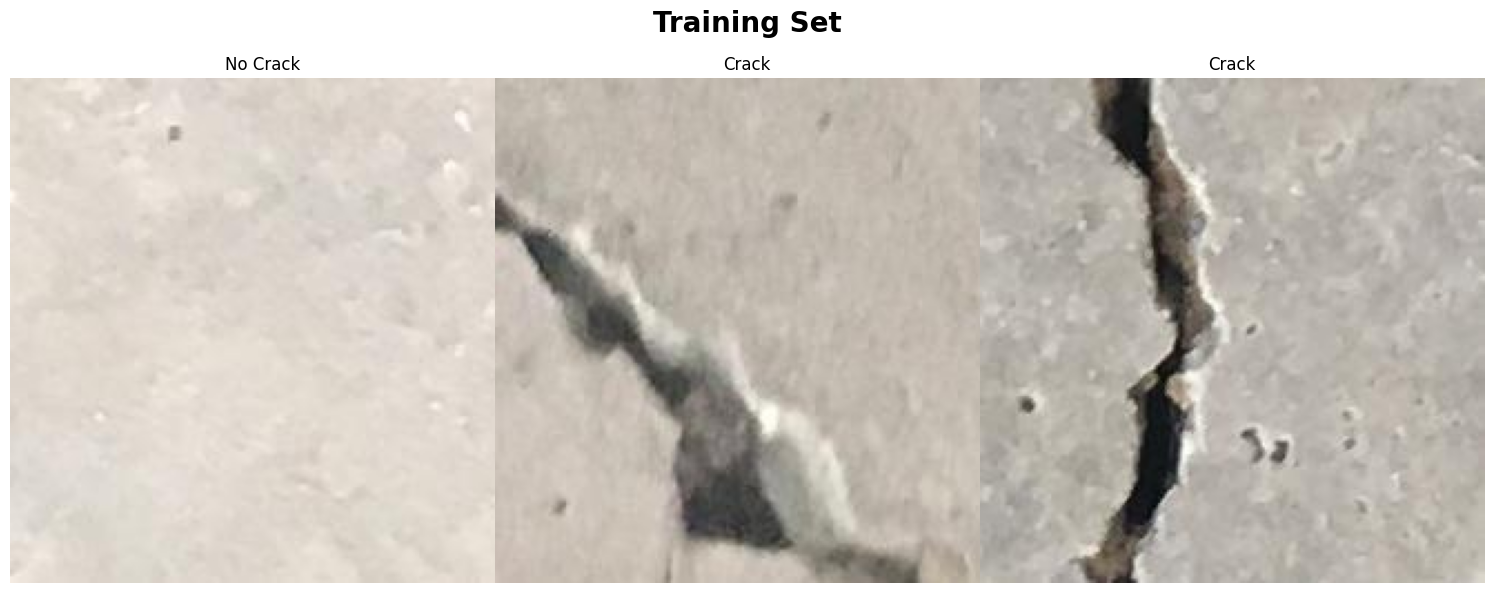

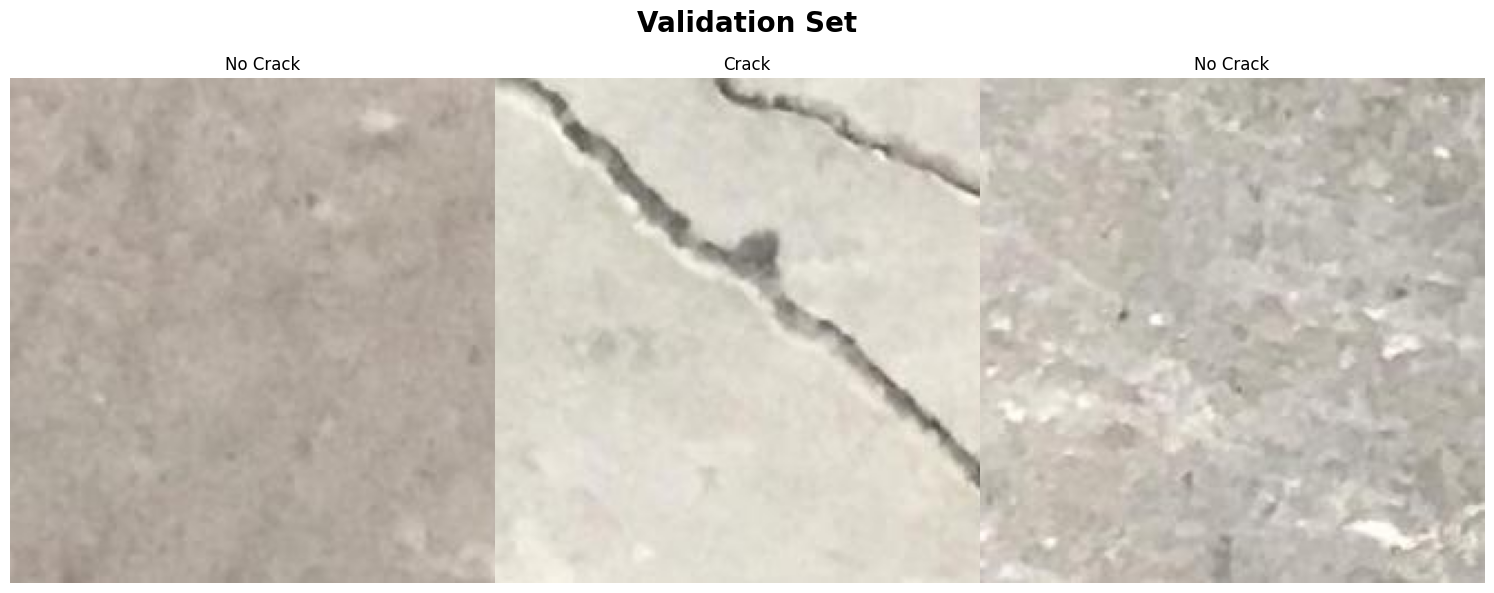

In [74]:
# Create non-normalized datasets for visualization
dataset_train_visualise = Dataset(transform = transforms.ToTensor(), train=True) 
dataset_val_visualise = Dataset(transform = transforms.ToTensor(), train=False) 

print('\n\033[1m\033[4mSample data:\033[0m\n')
show_data(dataset_train_visualise, 'Training Set') # Show training samples
show_data(dataset_val_visualise, 'Validation Set') # Show validation samples

## <a id="S3"></a> 3. Build Models

We will build two models: a simple linear classifier (SoftMax) and a pre-trained ResNet model. Pre-trained models have been trained on large datasets and can be fine-tuned for specific tasks, often leading to better performance.

### Linear classifier (SoftMax)

A SoftMax classifier is a basic linear model suitable for binary classification. 

In [8]:
image_size = dataset_train[0][0].numel() # Calculate flattened image size

class SoftMax(nn.Module):
    """ A simple Softmax linear classifier."""
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size) # Define linear layer
        
    # Prediction
    def forward(self, x):
        """ Forward pass of the model."""
        z = self.linear(x)
        return z
    
num_classes = 2 # Binary classification: crack or no crack
model_SM = SoftMax(image_size, num_classes) # Instantiate Softmax model

### Pre-trained ResNet

ResNet is a powerful convolutional neural network architecture that has shown excellent performance in image classification tasks. We use a pre-trained ResNet18 model and fine-tune it for our crack detection task.  We replace the last layer of the pre-trained ResNet model with a new layer suitable for our binary classification problem. 

In [9]:
# Load pre-trained resnet18 model
model_RN = models.resnet18(pretrained = True)

# Set the requires_grad attribute of the parameters to False to prevent the pre-trained weights from being updated during training
for param in model_RN.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
model_RN.fc = nn.Linear(512, 2) # 512 is the number of input features to the last layer, 2 is the number of output classes

/Users/isabelle/.pyenv/versions/3.12.5/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/isabelle/.pyenv/versions/3.12.5/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## <a id="S4"></a> 4. Train the Models

The train function performs the training loop:

1. Forward Pass: The model makes predictions on the input images.

2. Loss Calculation: The loss function compares the predictions to the actual labels.

3. Backward Pass: The gradients of the loss with respect to the model parameters are calculated.

4. Optimisation: The optimiser updates the model parameters to minimise the loss.

We also calculate the validation accuracy to monitor the model's performance on unseen data. 

### Define optimiser and loss function

In [10]:
# Using stochastic gradient descent for the soft max linear classifier
optimizer_SM = optim.SGD(model_SM.parameters(), lr = 0.1, momentum = 0.1)  

# Using the Adam optimizer for the pre-trained ResNet model
optimizer_RN = torch.optim.Adam([parameters  for parameters in model_RN.parameters() if parameters.requires_grad],lr=0.001)

# Loss function for classification
criterion = nn.CrossEntropyLoss()

### Fit and train

In [14]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100, flatten=False):
    """ Trains a given model."""
    
    cost_list=[]
    accuracy_list=[]
    
    for epoch in range(epochs):
        cost_iter=[]
        model.train() # Set model to training mode
        for x, y in train_loader:
            optimizer.zero_grad() # Zero gradients
            
            # Forward pass: calculate model output
            if flatten:
                z = model(x.view(batch_size,-1)) # Flatten input for the linear classifier
            else:
                z = model(x)
                
            loss = criterion(z, y) # Calculate loss
            loss.backward() # Backpropagation
            optimizer.step() # Update weights
            
            cost_iter.append(loss.data)
        cost_list.append(cost_iter)
        
        correct = 0
        length = 0
        model.eval() # Set model to evaluation mode
        for x, y in validation_loader:
            # Forward pass: calculate model output
            if flatten:
                z = model(x.view(batch_size,-1))
            else:
                z = model(x)
            _, label = torch.max(z, 1) # Get predicted labels
            correct += (label == y).sum().item() # Count correct predictions
            length += len(y) # Count total samples
    
        accuracy = 100 * (correct / length) # Calculate accuracy
        accuracy_list.append(accuracy)
    
    return cost_list, accuracy_list

Now, we train both the SoftMax classifier and the ResNet model. We train the SoftMax classifier for 3 epochs and the ResNet model for only 1 epoch since it's a pre-trained model and doesn't need as much training.

In [15]:
# train the soft max linear classifer
n_epochs = 3 # Number of epochs for Softmax model
cost_SM, accuracy_SM = train(model_SM, criterion, train_loader, validation_loader, optimizer_SM, epochs=n_epochs, flatten = True)

In [16]:
# train the pre-trained ResNet classifier
n_epochs = 1 # Number of epochs for ResNet model
cost_RN, accuracy_RN = train(model_RN, criterion, train_loader, validation_loader, optimizer_RN, epochs=n_epochs)

## <a id="S5"></a> 5. Model Prediction and Evaluation

We plot the training loss and validation accuracy to visualize the training process and evaluate the models' performance. We also print the final validation accuracies. 

### Training loss and validation accuracy

In [59]:
# Print validation accuracies
accuracy_SM = np.array(accuracy_SM).max() # Max accuracy for Softmax
accuracy_RN = np.array(accuracy_RN).max() # Max accuracy for ResNet

print(f'Linear classifier (soft max) validation accuracy: {accuracy_SM:.2f}%')
print(f'Pre-trained ResNet validation accuracy: {accuracy_RN:.2f}%')

Linear classifier (soft max) validation accuracy: 92.06%
Pre-trained ResNet validation accuracy: 99.31%


In [56]:
def plot_cost_and_accuracy(cost_lists, accuracy_lists, model_names,ylim_loss):
    """ Plots the training loss and validation accuracy for multiple models."""
    num_models = len(cost_lists)
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # Create subplots

    # Plotting Cost with Epoch-Level X-Axis and Vertical Lines
    ax1 = axs[0]  # Access the first subplot
    max_epochs = max(len(cost_list) for cost_list in cost_lists)  # Find max epochs from all models
    epoch_positions = np.arange(0, max_epochs) # Define epoch positions for x-axis 
    
    for i, cost_list in enumerate(cost_lists):
        epochs = len(cost_list) # Get number of epochs for current model 
        all_costs = [cost.item() for sublist in cost_list for cost in sublist] # Flatten cost list
        x_values = np.linspace(0, epochs, len(all_costs))  # Normalize x-axis to epochs
        ax1.plot(x_values, all_costs, label=f'{model_names[i]} (Epochs: {epochs})') # Plot cost

    ax1.set_xticks(epoch_positions) # Set x-axis ticks
    ax1.set_xticklabels([f'Epoch {epoch+1}' for epoch in range(max_epochs)]) # Set x-axis labels to epochs
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(axis='y')  # Keep y-axis grid
    ax1.set_ylim(ylim_loss) # Set y-axis limits to those provided in the input

    # Add vertical lines to separate epochs
    for epoch in range(1, epochs):
        ax1.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)

    # Plotting Validation Accuracy
    ax2 = axs[1]  # Access the second subplot
    for i, accuracy_list in enumerate(accuracy_lists):
        epochs = len(accuracy_list) # Get number of epochs 
        ax2.plot(range(1, epochs + 1), accuracy_list, marker='o', label=f'{model_names[i]} (Epochs: {epochs})') # Plot accuracy 
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Accuracy (%)')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim([80, 100])
    
    plt.tight_layout()
    plt.show()

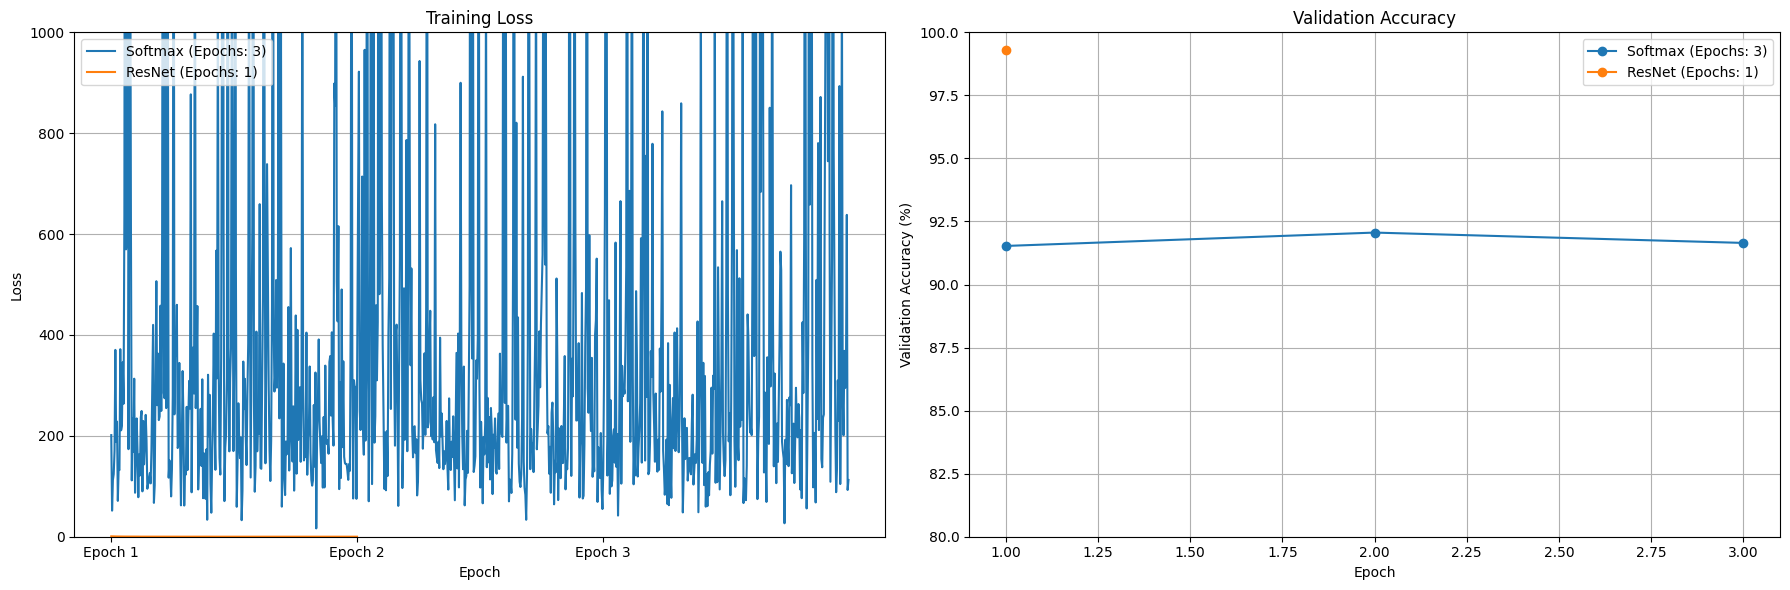

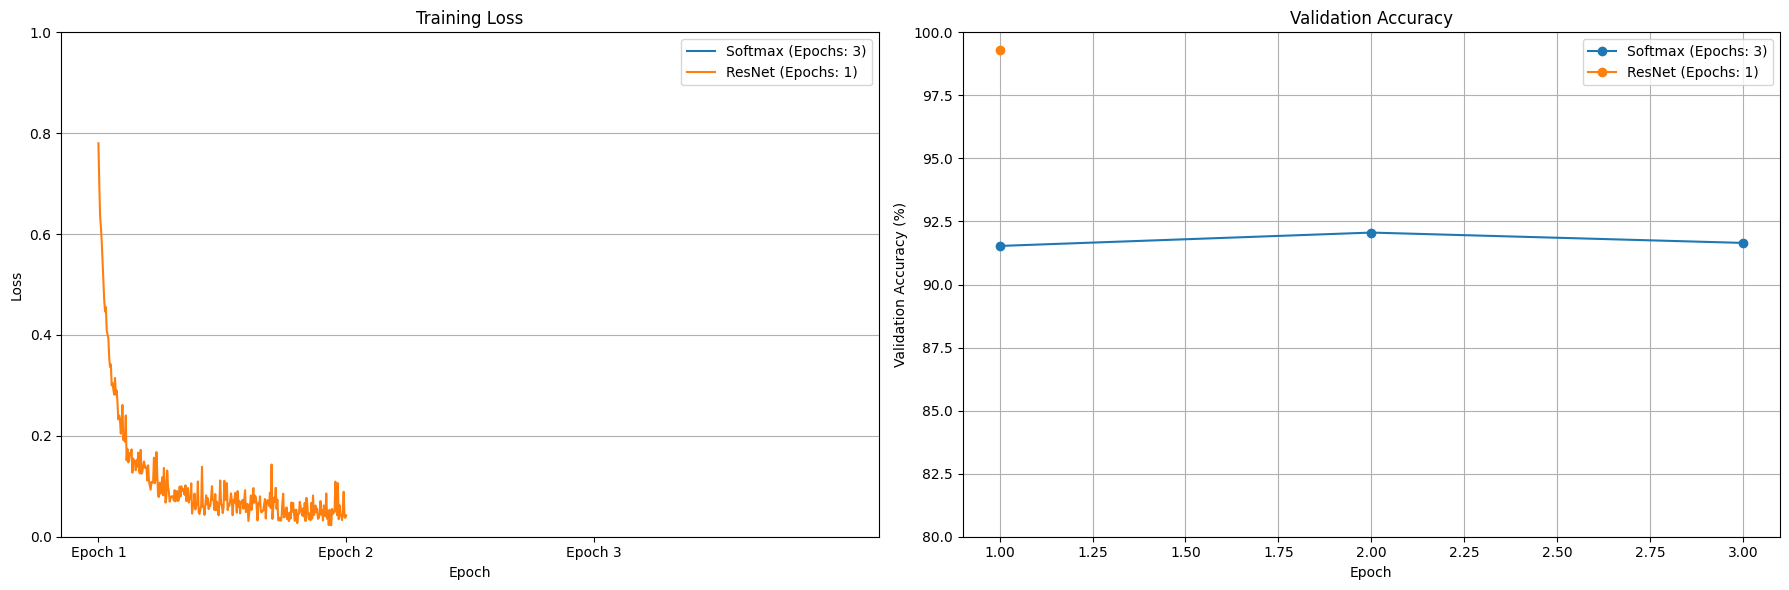

In [53]:
ylim_loss=[0, 1000] # Large y-axis limits for loss plot to visualise large and noisy softmax losses
plot_cost_and_accuracy([cost_SM, cost_RN], [accuracy_SM, accuracy_RN], ['Softmax', 'ResNet'], ylim_loss)

ylim_loss=[0, 1] # Small y-axis limits for loss plot to visualise the converging ResNet losses
plot_cost_and_accuracy([cost_SM, cost_RN], [accuracy_SM, accuracy_RN], ['Softmax', 'ResNet'], ylim_loss)

### Examples of missclassified samples


First four misclassified samples of the linear classifier model:

Sample: 67, Predicted value: 0, Actual value: 1
Sample: 79, Predicted value: 0, Actual value: 1
Sample: 89, Predicted value: 0, Actual value: 1
Sample: 95, Predicted value: 0, Actual value: 1




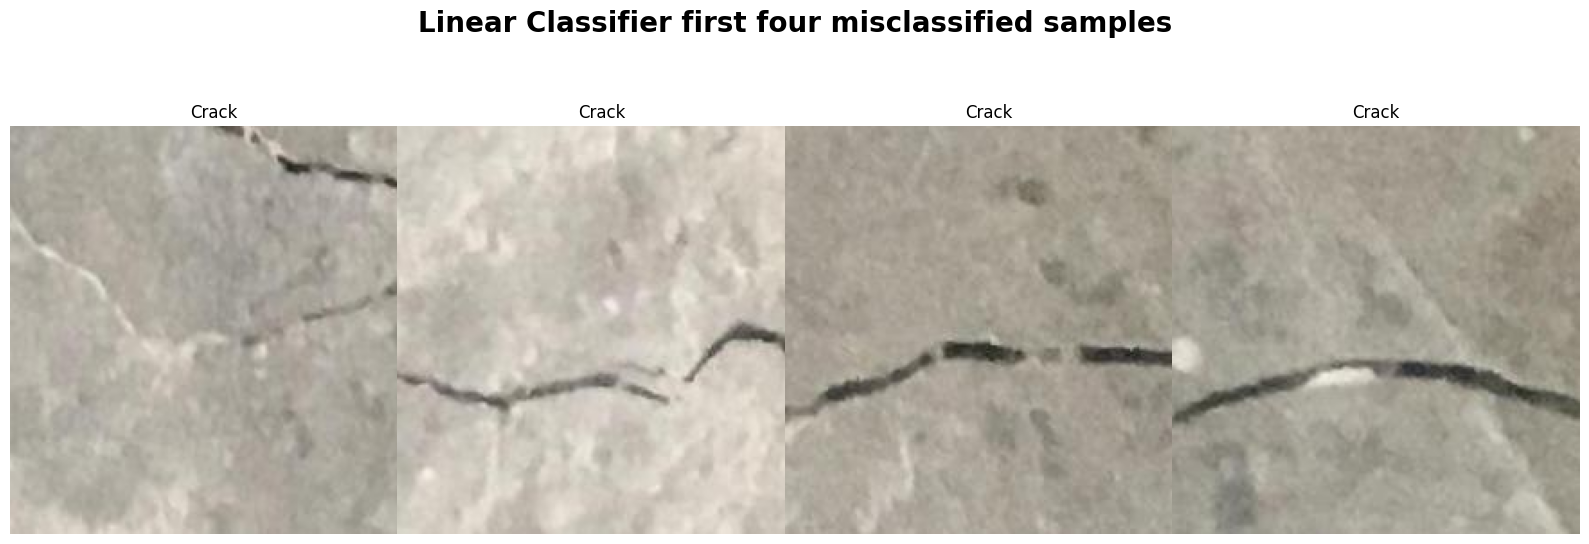


First four misclassified samples of the ResNet model:

Sample: 34, Predicted value: 1, Actual value: 0
Sample: 41, Predicted value: 0, Actual value: 1
Sample: 101, Predicted value: 0, Actual value: 1
Sample: 202, Predicted value: 1, Actual value: 0




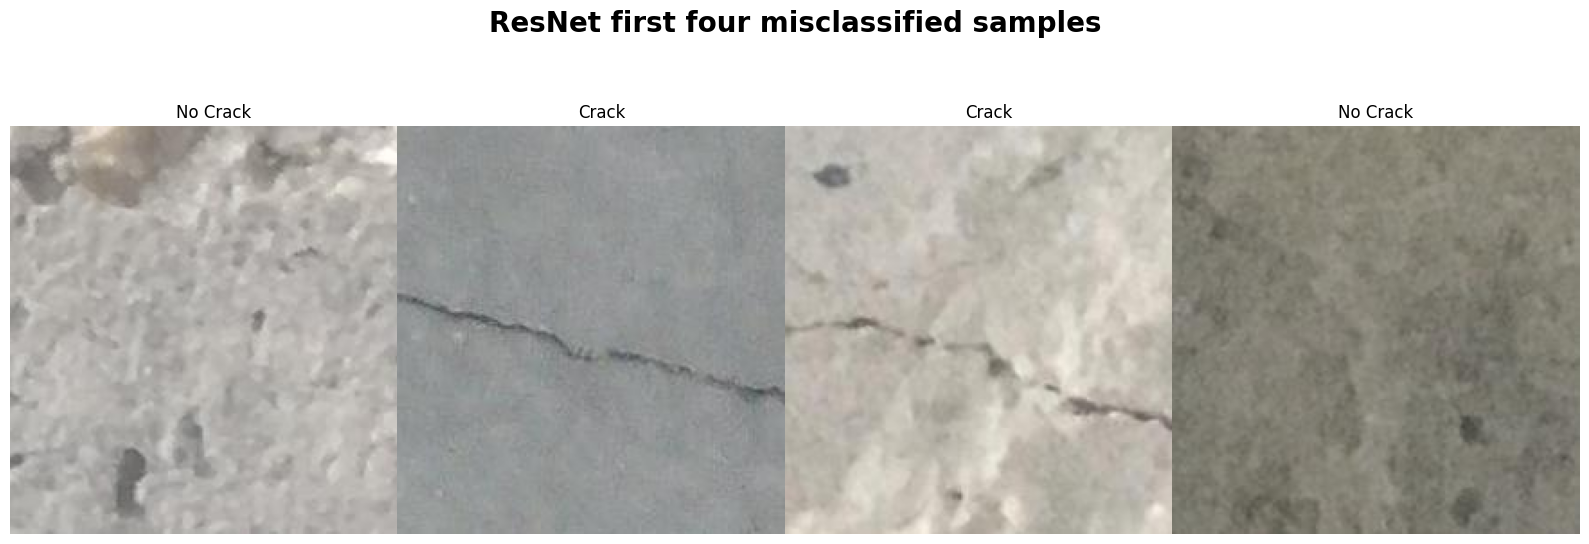

In [102]:
def show_misclassified(model, dataset, dataset_visualise, model_name):
    """ Identifies and displays the first four misclassified samples from the validation set."""

    model.eval() # Set model to evaluation mode
    count = 0
    misclassified_idx = []

    for i in range(len(dataset)):
        x, y = dataset[i] # Get sample
        if model_name == 'ResNet':
            z = model(x.unsqueeze(0))
        else:
            z = model(x.view(1, -1)) # Forward pass
        label = torch.max(z, 1)[1] # Get predicted label [cite: 66]

        if label != y: # Check for misclassification
            print(f'Sample: {i+1}, Predicted value: {label.item()}, Actual value: {y}') # Print info
            count += 1
            misclassified_idx.append(i)

        if count == 4:
            break
    print('\n')
    show_data(dataset_visualise, f'{model_name} first four misclassified samples', misclassified_idx)
    
# Visualise misclassified samples
print('\n\033[1mFirst four misclassified samples of the linear classifier model:\033[0m\n') # [cite: 19]
show_misclassified(model_SM, dataset_val, dataset_val_visualise, 'Linear Classifier')

print('\n\033[1mFirst four misclassified samples of the ResNet model:\033[0m\n') # [cite: 19]
show_misclassified(model_RN, dataset_val, dataset_val_visualise, 'ResNet')

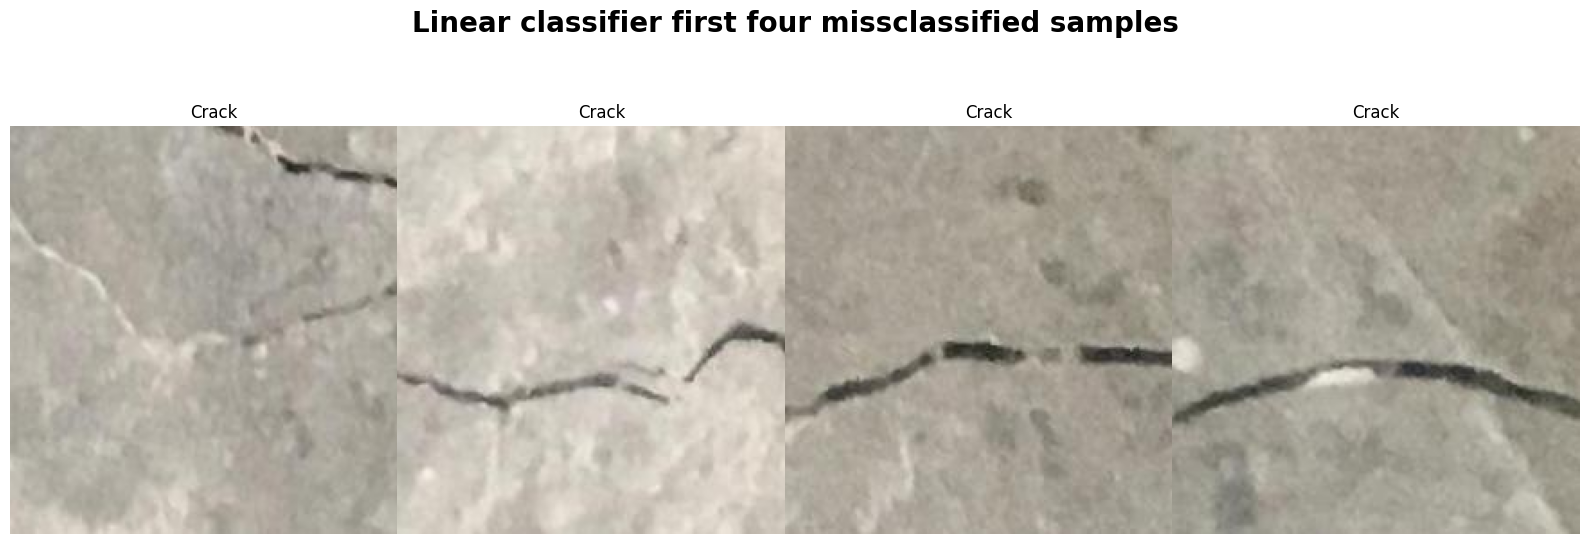

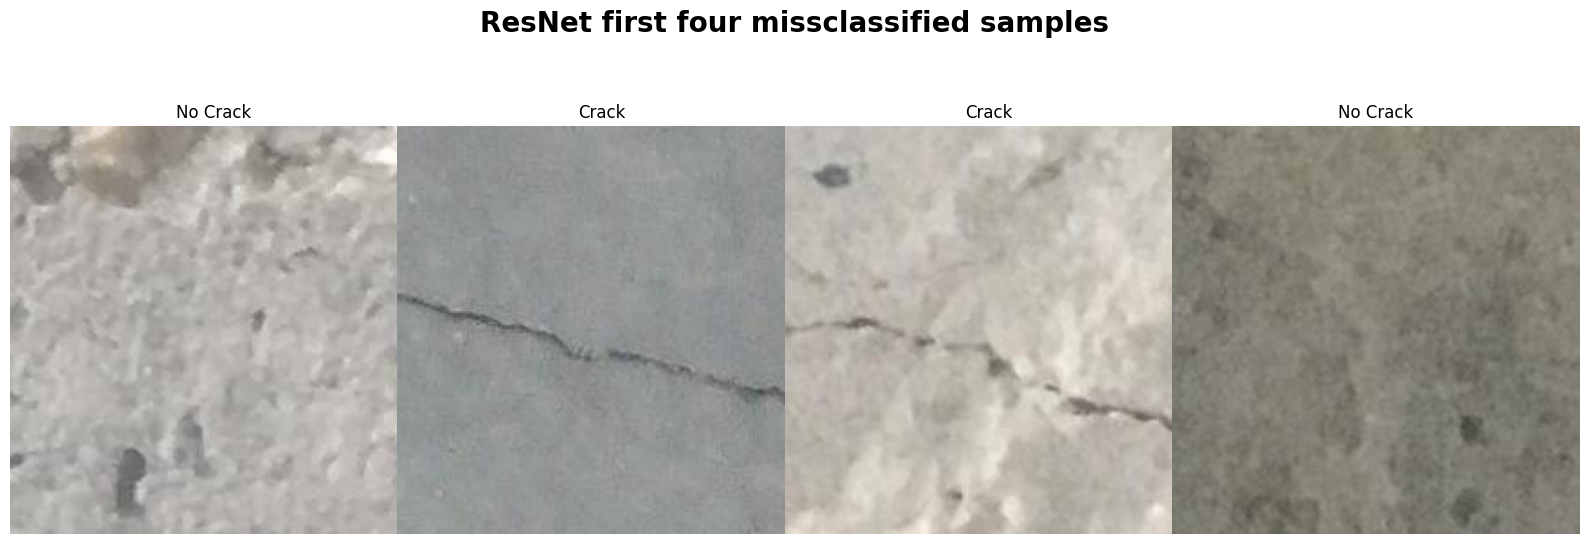

In [ ]:
show_data(dataset_val_visualise, 'Linear classifier first four missclassified samples', missclassified_idx_SM)
show_data(dataset_val_visualise, 'ResNet first four missclassified samples', missclassified_idx_RN)